In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import math
import urllib.request as urllib2
import datetime
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import sys
# !{sys.executable} -m pip install bibtexparser
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install unidecode
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import nltk.stem as stem
from nltk.corpus import stopwords
import string
import unidecode
import random
import torch
import bibtexparser

pd.set_option('mode.chained_assignment','warn')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lsfer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [4]:
def transform_date(yyyymmdd):
    try:
        d=datetime.datetime.strptime(yyyymmdd,'%Y-%m-%d')
        string_v=yyyymmdd
    except:
        string_v=yyyymmdd.strftime('%Y-%m-%d')
        d=datetime.datetime.strptime(string_v,'%Y-%m-%d')
    return string_v,datetime.date(d.year,d.month,d.day)

today=transform_date(datetime.datetime.today())
start_date=transform_date("2010-01-01")

In [5]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:quant-ph",start_date="1994-06-01",end_date=today[0]):
    print(f"Downloading section {arxiv} from {start_date} to {end_date}")
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = (f"{base_url}from={start_date}&until={end_date}&metadataPrefix=arXiv&set=%s"%arxiv)
    
    while True:
        print ("fetching", url)
        try:
            response = urllib2.urlopen(url)
            
        except urllib2.HTTPError as e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print ("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)
#         print(root)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            try:
                info = meta.find(ARXIV+"arXiv")
            except AttributeError:
                continue
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "resumptionToken=%s"%(token.text)
            
    return df

In [6]:
df = harvest(arxiv="physics:quant-ph",start_date=start_date[0],end_date=today[0])
df.to_csv("ArXiv.csv",index=False)
df.head()

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2018-01-01&until=2020-01-22&metadataPrefix=arXiv&set=physics:quant-ph
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|5001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|6001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|7001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|8001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|9001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4183400|10001
fetching http://export.arxiv.

,title,abstract,categories,created,id,doi
0,Geometric Phase and Superconducting Flux Quant...,In a ring of s-wave superconducting material t...,[quant-ph],2007-04-05,0704.0803,None
1,Projective Hilbert space structures at excepti...,A non-Hermitian complex symmetric 2x2 matrix t...,"[math-ph, cond-mat.other, math.MP, quant-ph]",2007-04-10,0704.1291,10.1088/1751-8113/40/30/014
2,A remark on helical waveguides,Motivated by a proposal to create an optical h...,"[quant-ph, cond-mat.mes-hall, math-ph, math.MP]",2007-04-20,0704.2770,10.1016/j.physleta.2007.05.013
3,Nontrivial edge coupling from a Dirichlet netw...,In distinction to the Neumann case the squeezi...,"[math-ph, cond-mat.mes-hall, math.MP, math.SP,...",2007-04-23,0704.2912,10.1088/1751-8113/40/26/F02
4,Smooth R\'enyi Entropy of Ergodic Quantum Info...,We prove that the average smooth Renyi entropy...,"[quant-ph, cs.IT, math.IT]",2007-04-26,0704.3504,None


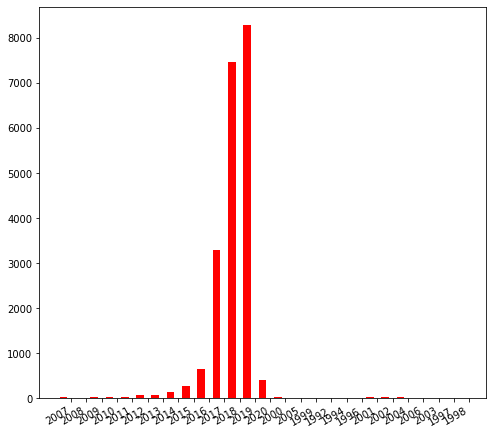

Unique arXiv IDs edited between 2018 and 2020: 20980
of which 16143 entries were created in that time period.


In [9]:
def bar_chart(items):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(ind, items.values(), width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(items.keys())
    fig.autofmt_xdate()
    plt.show()

edits_per_year = Counter(df.created.map(lambda x: x.year))
bar_chart(edits_per_year)
years=list(range(int(start_date[1].year),int(today[1].year)+1))
new_articles = sum(edits_per_year[year] for year in years)
print (f"Unique arXiv IDs edited between {years[0]} and {years[-1]}: {len(df.id.unique())}")
print ("of which %i entries were created in that time period."%(new_articles))

In [ ]:
# df[df.created<datetime.date(2019,1,1)]

In [ ]:
# len(df.id)

In [ ]:
def get_cites(arxiv_id):
    cites = []
    base_url = "http://inspirehep.net/search?p=refersto:%s&of=hx&rg=250&jrec=%i"
    offset = 1
    
    while True:
        print (base_url%(arxiv_id, offset))
        response = urllib2.urlopen(base_url%(arxiv_id, offset))
        xml = response.read()
        soup = BeautifulSoup(xml)

        refs = "\n".join(cite.get_text() for cite in soup.findAll("pre"))
#         with open("refs.txt","w+") as refs_file:
#             refs_file.write(refs)
        if len(refs)>0:
            bib_database = bibtexparser.loads(refs)
        else:
            continue
        if len(bib_database.entries)>0:
            cites += bib_database.entries
            offset += 250
        else:
            break

    return cites

# step = 1000
# lim=len(df.id)
# for N in range(0,20):
#     print (N)
#     cites = df['id'][N*step:min((N+1)*step,lim)].map(get_cites)
#     print(cites)
#     df.ix[N*step:(N+1)*step -1,'cited_by'] = cites
#     print("-"*100)

In [ ]:
# save file here

In [10]:
word_bag = " ".join(df.abstract.apply(lambda t: t.lower()))
Counter(word_bag.split()).most_common(n=10)

[('the', 211613),
 ('of', 134333),
 ('a', 85705),
 ('and', 67994),
 ('in', 65801),
 ('to', 60866),
 ('we', 52664),
 ('quantum', 48509),
 ('is', 40375),
 ('for', 36939)]

{'quantum': 48509, 'states': 8953, 'state': 8935, 'show': 8854, 'system': 7027, 'using': 6852, 'classical': 6045, 'entanglement': 5738, 'results': 4978, 'systems': 4656, 'information': 4605, 'phase': 4528, 'model': 4478, 'time': 4460, 'study': 4389, 'based': 4328, 'field': 4088, 'number': 4017, 'spin': 3921, 'different': 3852}


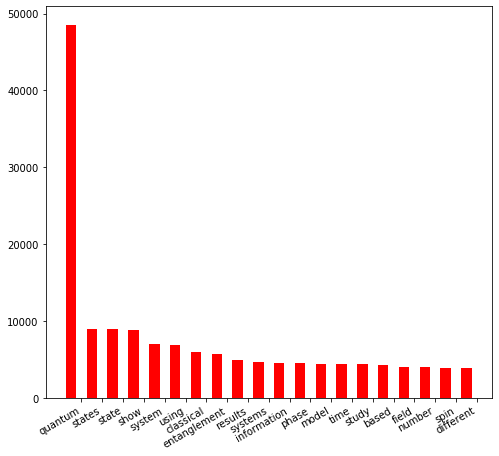

In [13]:
stops = [word for word in stopwords.words('english')]
stops += ["=", "->","one","two","also"]
words = filter(lambda w: w not in stops,word_bag.split())
top_twenty = {l[0]:l[1] for l in Counter(words).most_common(n=20)}
print(top_twenty)
bar_chart(top_twenty)

In [14]:
porter = stem.PorterStemmer()
for w in ("measurement", "measurements", "measured", "measure"):
    print (w, "->", porter.stem(w))

measurement -> measur
measurements -> measur
measured -> measur
measure -> measur


In [15]:
words=list(filter(lambda w: w not in stops,word_bag.split()))

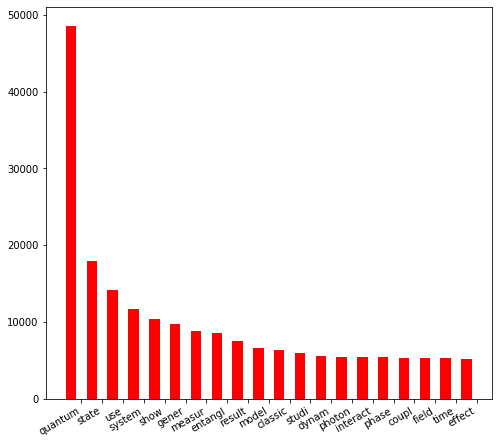

quantum <- quantum, quantumness, quantumnesses, quantums
state <- states, state, stated, stating, stateful
use <- used, usefulness, using, use, useful, uses, usefully
system <- system, systems
show <- show, showing, showed, shows
gener <- generically, general, generalized, generated, generation, generalizing, generalize, generic, generate, generally, generalization, generations, generating, generates, generalizes, generators, generalizations, generator, generality, generative, genericity
measur <- measure, measured, measurements, measurement, measures, measurability, measurable, measuring, measurment, measurer, measureable, measurably
entangl <- entanglement, entangled, entangling, entangle, entangler, entanglers, entanglment, entanglements, entangles, entangleable
result <- result, resulting, results, resultant, resulted
model <- model, models, modeled, modelled, modeling, modelling
classic <- classical, classically, classicality, classic, classicalization, classicalizing, classicaliz

In [16]:
word_stems = [(porter.stem(w),w) for w in words]
# print(word_stems)
stem2words = {}
for _ in word_stems:
    stem, word = _[0],_[1]
    if stem not in stem2words.keys():
        stem2words[stem]=[word]
    else:
        if word not in stem2words[stem]:
            stem2words[stem].append(word)
        else:
            continue
# print(stem2words)
top_twenty = {l[0]:l[1] for l in Counter(w[0] for w in word_stems).most_common(n=20)}
# print(top_twenty)
bar_chart(top_twenty)

# list all words which correspond to each top twenty stem
for stem,count in top_twenty.items():
    print (stem, "<-", ", ".join(stem2words[stem]))

In [ ]:
# before_2019 = datetime.datetime(2019,1,1)
# plt.hist(df[df.created<before_2019].cited_by.map(len),bins=200, normed=True, range=(0,200))
# plt.xlabel("Number of citations")
# plt.ylabel("Fraction")

In [ ]:
# df['citation_count'] = df.cited_by.map(len)
# df[df.created<before_2019]['citation_count'].describe()

In [ ]:
# df.iloc[df.citation_count.idxmax()]

In [ ]:
# df.sort('citation_count', ascending=False).head(10)

In [ ]:
# df.iloc[df[df.created>before_2019].citation_count.idxmax()]

In [18]:
del words, word_stems, stem2words

In [ ]:
##########################end of first notebook https://nbviewer.jupyter.org/url/betatim.github.io//downloads/notebooks/arXiv.ipynb

In [ ]:
#next notebook here : https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch

In [17]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [19]:
text_title = list(df.title)
print(text_title[0])
def joinStrings(text):
    return ' '.join(string for string in text)
text_title = joinStrings(text_title)
len(text_title.split())

Geometric Phase and Superconducting Flux Quantization


194519

In [20]:
text_abst=list(df.abstract)
text_abstract=[s.replace("\n"," ") for s in text_abst]
print(text_abstract[0])
text_abstract = joinStrings(text_abstract)
len(text_abstract.split())
del text_abstract, text_abst

In a ring of s-wave superconducting material the magnetic flux is quantized in units of $\Phi_0 = \frac{h}{2e}$. It is well known from the theory of Josephson junctions that if the ring is interrupted with a piece of d-wave material, then the flux is quantized in one-half of those units due to a additional phase shift of $\pi$. We reinterpret this phenomenon in terms of geometric phase.   We consider an idealized hetero-junction superconductor with pure s-wave and pure d-wave electron pairs. We find, for this idealized configuration, that the phase shift of $\pi$ follows from the discontinuity in the geometric phase and is thus a fundamental consequence of quantum mechanics.


2958112

In [23]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
# test_sentence = clean(text_abstract).lower().split()
test_sentence = clean(text_title).lower().split()

In [ ]:
n=3 #for title n=3, rather 5 for abstract
ngrams = [([test_sentence[i+j] for j in range(n-1)], test_sentence[i + n-1])
            for i in range(len(test_sentence) - (n-1))]
chunk_len=len(ngrams)
print(ngrams[:3])

In [ ]:
vocab = set(test_sentence) #careful !!!! in future include all words of titles + abstracts
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
inp=[]
tar=[]
for context, target in ngrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*(n-1), hidden_size, n_layers, batch_first=True,bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, inpt, hidden):
        inpt = self.encoder(inpt.view(1, -1))
        output, hidden = self.gru(inpt.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target):
    if train_on_gpu :
        hidden = decoder.init_hidden().cuda()
    else:
        hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        if train_on_gpu :
            inp[c]=inp[c].cuda()
            target[c] = target[c].cuda()
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [28]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
n_epochs = 5 #300
print_every = 1 #100
plot_every = 1 #10
hidden_size = 10 #100
n_layers = 1
lr = 0.015
torch.cuda.empty_cache()
decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if train_on_gpu :
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    if train_on_gpu :
        hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [ ]:
print(evaluate('A Quantum', 10, temperature=1))